# AI Workflows and Agents

In [1]:
from IPython.display import display, Markdown

import os
from groq import Groq
import re
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict, Tuple, Optional, Any
from pprint import pprint
import json

from dotenv import load_dotenv

In [ ]:
load_dotenv()

In [3]:
# PARAMETERS
model_name = "mixtral-8x7b-32768"  # "mixtral-8x7b-32768"

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

## Workflows
The paper defines 5 types of workflows:
1. Prompt Chaining
2. Routing
3. Parallelization
4. Orchestrator-workers
5. Evaluator-optimizer

In [4]:
# Common functions
def llm_call(prompt: str, system_prompt: str = '', tools: list | None = None, tool_choice: str = 'none' ) -> str:
    """
    Calls the LLM API with the given prompt.
    Args:
        prompt (str): The prompt to send to the API.
        system_prompt (str): The system prompt to send to the API.
        tools (list): The tools to use.
        tool_choice (str): The tool choice to use. Can be either 'none', 'auto', or 'human'.

        Returns:
        str: The response from the LLM.
    """

    messages = []

    if system_prompt:
        messages.append({
            "role": "system",
            "content": system_prompt
        })

    messages.append({
        "role": "user",
        "content": prompt
    })

    chat_completion = client.chat.completions.create(
        messages=messages,
        model = model_name,
        temperature=0.1,
        tools=tools,
        tool_choice=tool_choice
    )

    return chat_completion.choices[0].message.content


def extract_xml(text: str, tag: str) -> str:
    """
    Extracts the content of the specified XML tag from the given text.
    Used for parsing structured responses
    Args:
        text (str): The text containing the XML.
        tag (str): The XML tag to extract content from.
    
    Returns:
        str: The content of the specified XML tag,
        or an empty string if the tag is not found.
    """
    match = re.search(f'<{tag}>(.*?)</{tag}>', text, re.DOTALL)
    
    extraction = ''
    if match:
        extraction = str(match.group(1)).strip()

    return extraction 

### Workflow 1: Prompt Chaining

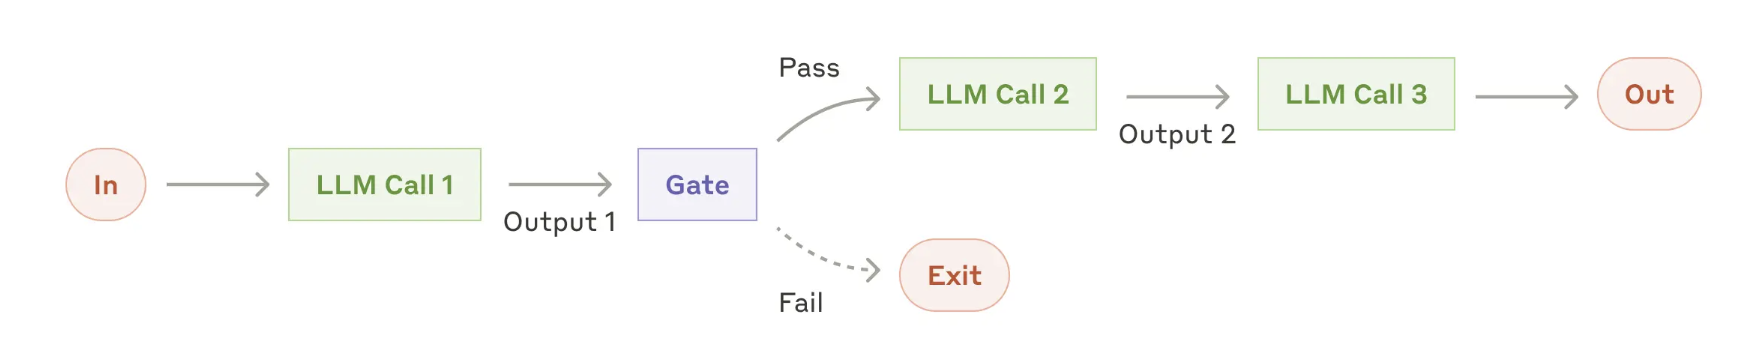

In [6]:
def prompt_chaining(input_text: str, steps: List[str]) -> str:
    """
    Execute a sequence of LLM calls where each step's output
    becomes the next step's input.
    Args:
        input_text: Initial text to process
        steps: List of prompts/instructions for each step
    Returns:
        Final processed text after all steps
    """
    current_text = input_text
    
    for step_nr, step_prompt in enumerate(steps, 1):
        print(f"\nStep {step_nr}:")

        # Combine the prompt with current text
        full_prompt = f"{step_prompt}\nInput: {current_text}"

        # Process through LLM
        current_text = llm_call(full_prompt)
        print(current_text)
        print("##################")

    return current_text

In [7]:
data_processing_steps = [
    """Extract only the numerical values and their associated metrics from the text.
    Format each as 'value: metric' on a new line.
    Example format:
    92: customer satisfaction
    45%: revenue growth
    """
    ,
    """Convert all numerical values to percentages where possible.
    If not a percentage or points, convert to decimal (e.g., 92 points -> 92%).
    Keep one number per line.
    Example format:
    92%: customer satisfaction
    45%: revenue growth
    """
    ,
    """Sort all lines in descending order by numerical value.
    Keep the format'value: metric' on each line.
    Example:
    92%: customer satisfaction
    87%: employee satisfaction
    """
    ,
    """Format the sorted data as a markdown table with columns:
    | Metric | Value |
    |:--|--:|
    | Customer Satisfaction | 92% |
    """
]

report = """
    Q3 Performance Summary:
    Our customer satisfaction score rose to 92 points this quarter.
    Revenue grew by 45% compared to last year.
    Market share is now at 23% in our primary market.
    Customer churn decreased to 5% from 8%.
    New user acquisition cost is $43 per user.report
    Product adoption rate increased to 78%.
    Employee satisfaction is at 87 points.
    Operating margin improved to 34%.
"""

In [ ]:
final_output = prompt_chaining(input_text = report, steps = data_processing_steps)

In [ ]:
print("\n---\nFinal Output:\n")
print(final_output)

In [ ]:
display(Markdown(final_output))

### Workflow 2: Routing

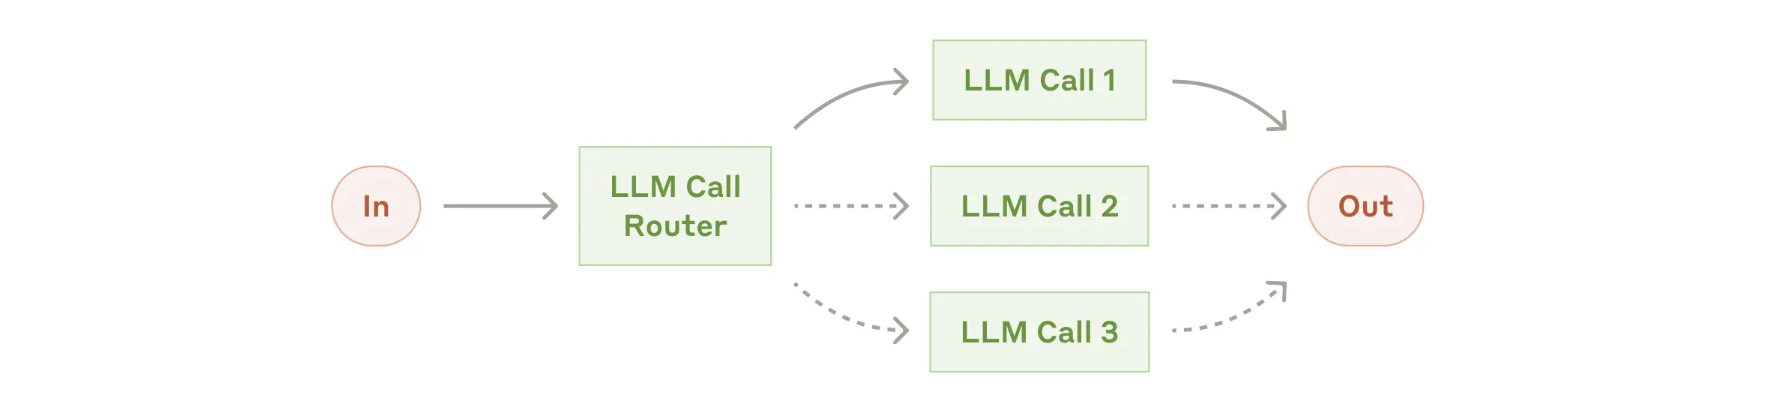

In [12]:
def routing(input_text: str, routes: Dict[str, str]) -> str:
    """
    Route input text to specialsed prompt using content classification.
    """

    print(f'\nAvailable routes: {list(routes.keys())}')
    selector_prompt = f"""
    Analyze the input and select the most appropriate support team from these options: {list(routes.keys())}

    First explain your reasoning, then provide your selection in this XML format:
    <reasoning>
    Brief explanation of why this ticket should be routed to a specific team.
    Consider key terms, user intent, and urgency level.
    </reasoning>

    <selection>
    The chosen team name
    </selection>

    Input: {input_text}
    """.strip()

    route_response = llm_call(selector_prompt)
    reasoning = extract_xml(route_response, 'reasoning')
    route_key = extract_xml(route_response, 'selection').strip().lower()

    print("Routing Analysis:")
    print(reasoning)
    print(f"\nSelected route: {route_key}")

    # Process input with selected specialised prompt
    selected_prompt = routes.get(route_key, "Default Support Team") 
    
    return llm_call(f"{selected_prompt}\nInput: {input_text}")

In [13]:
support_routes = {
    "billing": """You are a billing support specialist. Follow these guidelines:
    1. Always start with "Billing Support Response:"
    2. First acknowledge the specific billing issue
    3. Explain any charges or discrepancies clearly
    4. List concrete next steps with timeline
    5. End with payment options if relevant
    Keep responses professional but friendly.
    Input: """
    ,
    "technical": """You are a technical support engineer. Follow these guidelines:
    1. Always start with "Technical Support Response:"    
    2. List exact steps to resolve the issue
    3. Include system requirements if relevant
    4. Provide workarounds for common problems
    5. End with escalation path if needed
    Use clear, numbered steps and technical details.
    Input: """
    ,
    "account": """You are an account security specialist. Follow these guidelines:
    1. Always start with "Account Support Response:"
    2. Prioritize account security and verification
    3. Provide clear steps for account recovery/changes
    4. Include security tips and warnings
    5. Set clear expectations for resolution time
    Maintain a serious, security-focused tone.
    Input: """
    ,
    "product": """You are a product specialist. Follow these guidelines:
    1. Always start with "Product Support Response:"
    2. Focus on feature education and best practices
    3. Include specific examples of usage
    4. Link to relevant documentation sections
    5. Suggest related features that might help
    Be educational and encouraging in tone.
    Input: """
}
    
# Test with different support tickets
tickets = [
    """Subject: Can't access my account
    Message: Hi, I've been trying to log in for the past hour but keep
    getting an'invalid password' error.
    I'm sure I'm using the right password. Can you help me regain access?
    This is urgent as I need to
    submit a report by end of day.
    - John""" 
    ,
    """Subject: Unexpected charge on my card
    Message: Hello, I just noticed a charge of $49.99 on my credit card from
    your company, but I thought
    I was on the $29.99 plan. Can you explain this charge and adjust
    it if it's a mistake?
    Thanks,
    Sarah""" 
    ,
    """Subject: How to export data?
    Message: I need to export all my project data to Excel.
    I've looked through the docs but can't
    figure out how to do a bulk export. Is this possible?
    If so, could you walk me through the steps?
    Best regards,
    Mike"""
]

In [ ]:
print("Processing support tickets...\n")
for i, ticket in enumerate(tickets, 1):
    print(f"\nTicket {i}:")
    print('-'*50)
    print(ticket)
    print('-'*50)
    response = routing(ticket, support_routes)
    print(f"\nResponse:")
    print('='*50)
    print(response)
    print('='*50)

### Workflow 3: Parallelization

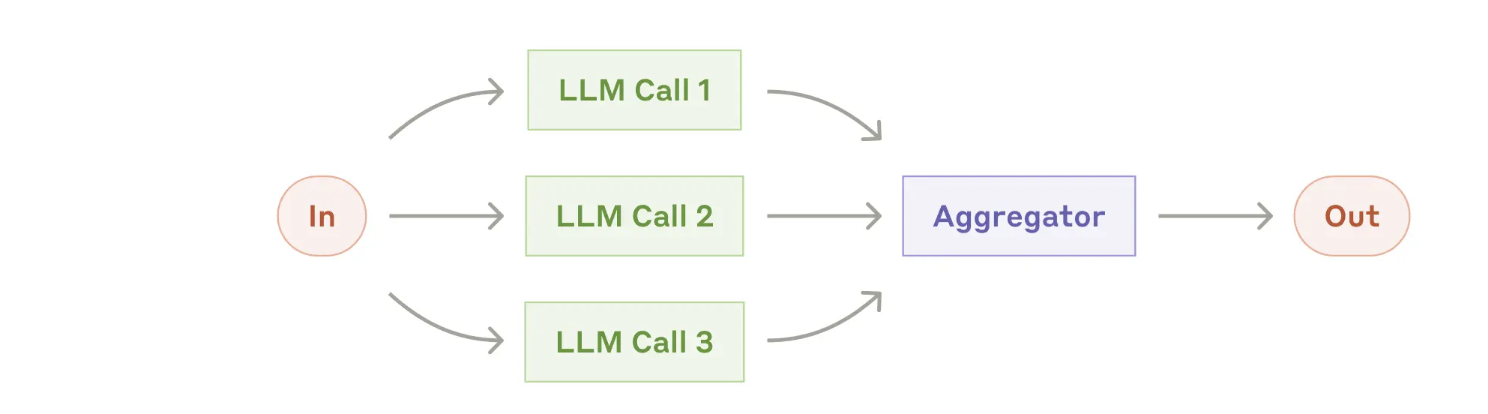

In [15]:
def parallel(prompt: str, inputs: List[str], n_workers: int = 3) -> List[str]:
    """
    Execute a function in parallel on a list of inputs.
    Args:
        prompt: Prompt to be used in each function call.
        inputs: List of input strings to process.
        func: Function to be executed on each input.
    Returns:
        List of outputs from the function calls.
    """
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(llm_call, f"{prompt}\nInput: {input_text}") for input_text in inputs]
    
    return [f.result() for f in futures]


In [16]:

stakeholders = [
    """Customers:
    - Price sensitive
    - Want better tech
    - Environmental concerns""" 
    ,
    """Employees:
    - Job security worries
    - Need new skills
    - Want clear direction""" 
    ,
    """Investors:
    - Expect growth
    - Want cost control
    - Risk concerns""" 
    ,
    """Suppliers:
    - Capacity constraints
    - Price pressures
    - Tech transitions"""
]

impact_results_prompt = """
Analyze how market changes will impact this stakeholder group.
Provide specific impacts and recommended actions.
Format with clear sections and priorities.
"""
impact_results = parallel(prompt = impact_results_prompt, inputs=stakeholders)  


In [ ]:

print('='*50)
print("Analysis Results for Each Stakeholder Group:")
print('='*50)

for i, result in enumerate(impact_results, 1):
    print(f"\n\nStakeholder Group {i}:")
    print('-'*50)
    print(result)
    print('='*50)

### Workflow 4: Orchestrator-worker

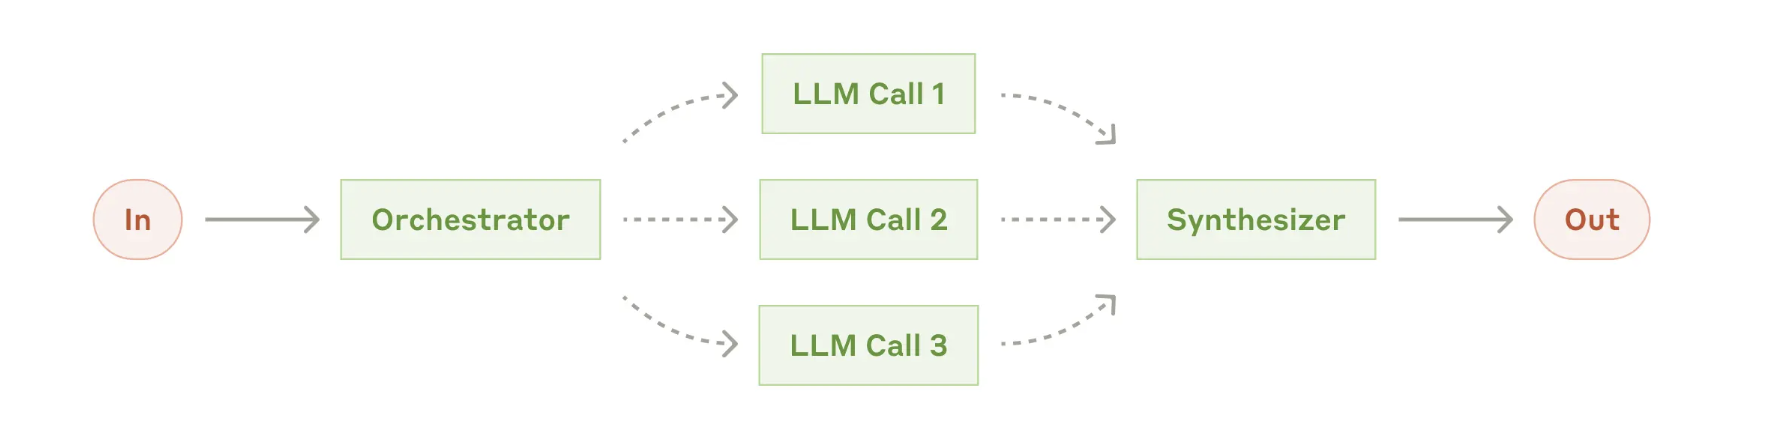

In [18]:
def orchestrator(task: str) -> List[Dict[str, Any]]:
    """
    Central function that breaks down the task using LLM.
    
    Args:
        task (str): The main task to be broken down
    
    Returns:
        List of subtask dictionaries
    """
    system_prompt = """
    You are a task orchestrator. Break down the given task into research and analysis subtasks.
    Return the result as a Python list of dictionaries, with each dictionary having 'type' and 'description' keys.
    Only return the Python list, no other text.
    """
    
    prompt = f"Break down this task into research and analysis subtasks: {task}"
    
    subtasks = []
    try:
        response = llm_call(prompt, system_prompt)
        # The LLM should return a string that can be evaluated as a Python list
        subtasks = eval(response)
        print(f"Orchestrator created subtasks")

    except Exception as e:
        print(f"Error in orchestrator: {e}")
        # Fallback subtasks in case of error
        subtasks.extend([
            {"type": "research", "description": f"Research about: {task}"},
            {"type": "analysis", "description": f"Analyze findings about: {task}"}
        ])

    return  subtasks


def research_worker(subtask: Dict[str, Any]) -> Dict[str, Any]:
    """
    Worker function specialized in research using LLM.
    
    Args:
        subtask (Dict): Subtask details from orchestrator
    
    Returns:
        Dict containing research results
    """
    system_prompt = """
    You are a research specialist. Provide detailed research findings about the given topic.
    Focus on gathering key information and important facts.
    """
    
    prompt = f"Conduct research on this task: {subtask['description']}"
    
    research_findings = llm_call(prompt, system_prompt)
    
    return {
        "type": "research",
        "results": research_findings
    }


def analysis_worker(subtask: Dict[str, Any]) -> Dict[str, Any]:
    """
    Worker function specialized in analysis using LLM.
    
    Args:
        subtask (Dict): Subtask details from orchestrator
    
    Returns:
        Dict containing analysis results
    """
    system_prompt = """
    You are an analysis specialist. Analyze the given topic and provide insights.
    Focus on implications, patterns, and meaningful conclusions.
    """
    
    prompt = f"Analyze this task: {subtask['description']}"
    
    analysis_insights = llm_call(prompt, system_prompt)
    
    return {
        "type": "analysis",
        "results": analysis_insights
    }


def synthesizer(worker_results: List[Dict[str, Any]], original_task: str) -> str:
    """
    Synthesizes results from different worker functions using LLM.
    
    Args:
        worker_results (List): Results from different worker functions
        original_task (str): The original task for context
    
    Returns:
        str: Synthesized final output
    """
    system_prompt = """
    You are a synthesis specialist. Combine and synthesize multiple pieces of information
    into a coherent, well-structured final report. Ensure the synthesis is comprehensive
    and addresses the original task.
    """
    
    # Prepare context for the LLM
    context = f"""
    Original Task: {original_task}

    Research Results:
    {worker_results[0]['results']}

    Analysis Results:
    {worker_results[1]['results']}

    Please synthesize these results into a comprehensive final report.
    """
    
    final_report = llm_call(context, system_prompt)
    return final_report


In [ ]:
initial_task = "Explain the impact of artificial intelligence on healthcare diagnostics"
print(f"\nProcessing task: {initial_task}\n")

In [ ]:

# Orchestrator breaks down the task
print("### Start Orchestrating subtasks...")
subtasks = orchestrator(initial_task)
print("\nSubtasks:")
pprint(subtasks)
print("### End Orchestrating subtasks...\n")


# Process subtasks with worker functions
print("### Start Processing subtasks...")
worker_results = []
for subtask in subtasks:
    if subtask['type'] == 'research':
        print("\nPerforming research...")
        research_subtask = research_worker(subtask)
        print("research_subtask:\n", research_subtask)
        worker_results.append(research_subtask)
    elif subtask['type'] == 'analysis':
        print("\nPerforming analysis...")
        analysis_subtask = analysis_worker(subtask)
        print("analysis_subtask:\n", analysis_subtask)
        worker_results.append(analysis_subtask)

print("### End Processing subtasks...\n")

# Synthesize results
print("### Start Synthesizing results...")
print("\nSynthesizing results...")
final_report = synthesizer(worker_results, initial_task)

# Print the final synthesized report
print("\nSynthesized, Final Report:")
print("=" * 80)
print(final_report)
print("=" * 80)

print("\n### End Synthesizing results...\n")

### Workflow 5: Evaluator-optimizer


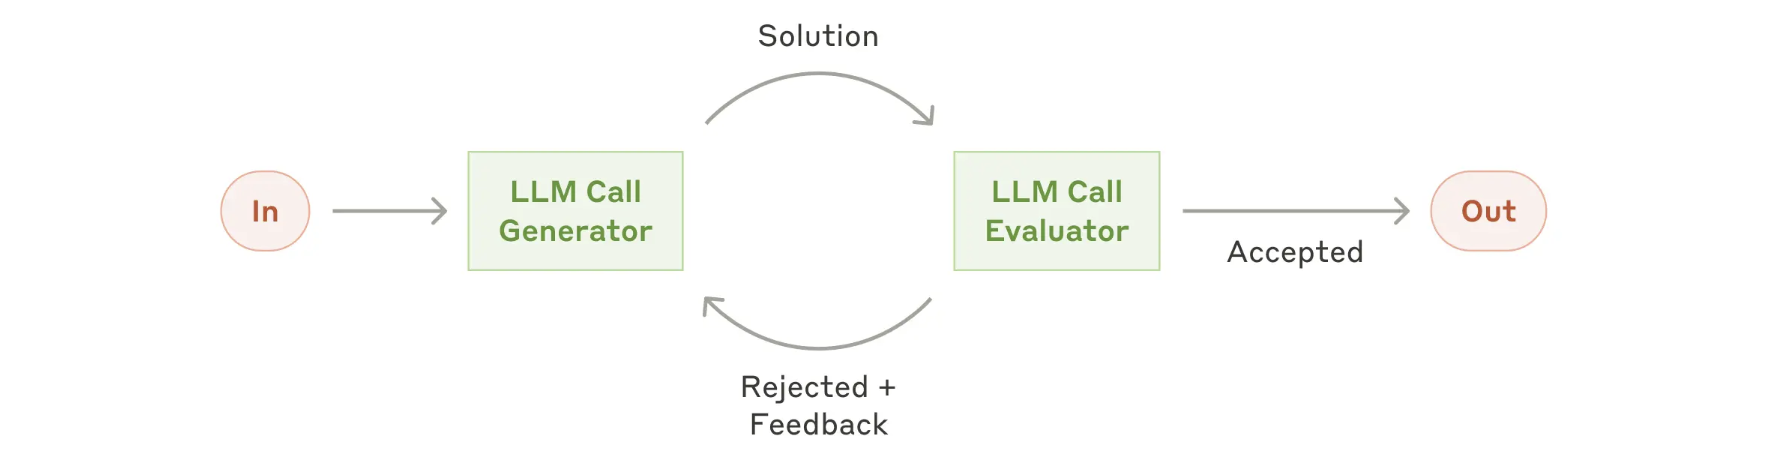

In [21]:
def generate(prompt: str, task: str, context: str = "") -> Tuple[str, str]:
    """Generate and improve a solution based on feedback."""
    full_prompt = f"{prompt}\n{context}\nTask: {task}" if context else f"{prompt}\nTask: {task}"
    response = llm_call(full_prompt)
    thoughts = extract_xml(response, "thoughts")
    result = extract_xml(response, "response")

    print("\n=== GENERATION START ===")
    print(f"Thoughts:\n{thoughts}\n")
    print(f"Generated:\n{result}")
    print("=== GENERATION END ===\n")

    return thoughts, result


def evaluate(prompt: str, content: str, task: str) -> Tuple[str, str]:
    """Evaluate if a solution meets requirements."""
    full_prompt = f"{prompt}\nOriginal task: {task}\nContent to evaluate:{content}"
    response = llm_call(full_prompt)
    evaluation = extract_xml(response, "evaluation")
    feedback = extract_xml(response, "feedback")

    print("=== EVALUATION START ===")
    print(f"Status: {evaluation}")
    print(f"Feedback: {feedback}")
    print("=== EVALUATION END ===\n")

    return evaluation, feedback


def eval_optimizer(task: str, evaluator_prompt: str, generator_prompt: str) -> Tuple[str, List[Dict[str, str]]]:
    """Keep generating and evaluating until requirements are met."""
    memory = []
    chain_of_thought = []
    thoughts, result = generate(generator_prompt, task)
    memory.append(result)
    chain_of_thought.append({"thoughts": thoughts, "result": result})
    improvement_count = 0

    while True:
        evaluation, feedback = evaluate(evaluator_prompt, result, task)
        if evaluation == "PASS":
            return result, chain_of_thought
        else:
            improvement_count += 1
            print(f'{improvement_count=}')
            
        if improvement_count >= 2:
            print("Too many improvements needed. Stopping the process.")
            return result, chain_of_thought
        
        context = "\n".join([
            "Previous attempts:"
            , 
            *[f"- {m}" for m in memory]
            ,
            f"\nFeedback: {feedback}"
        ])

        thoughts, result = generate(generator_prompt, task, context)
        memory.append(result)
        chain_of_thought.append({"thoughts": thoughts, "result": result})


In [22]:
evaluator_prompt = """
    Evaluate this following code implementation for:
    1.time complexity
    2.software engineering best practices
    You should be evaluating only and not attemping to solve the task.
    
    You need to output 'evaluation' and 'feedback':
    - evaluation: 
    -- PASS: if all criteria are met and you have no furthersuggestions for improvements
    -- NEEDS_IMPROVEMENT: if you believe there can be made significant improvements. Write the improvements in 'feedback'
    -- FAIL: if evaluation of the input does not make sense
    - feedback:
    Write a thorough, consistent and short feedback for what can be improved

    Output your evaluation concisely in the following xml format using the xml tags <evaluation> and <feedback>
    Remember to use both start and end tags
        <evaluation>
        One of PASS, NEEDS_IMPROVEMENT, or FAIL
        </evaluation>
        <feedback>
        What needs improvement and why.
        </feedback>

    XML example:
        <evaluation>
        PASS
        </evaluation>
        <feedback>
        The code does not use Python's built-in functions, such as XXX, which could significantly improve the computation time.
        </feedback>
"""

generator_prompt = """
    Your goal is to complete the task based on <user input>.
    If there are feedback
    from your previous generations, you should
    reflect on them to improve your solution
    Output your answer concisely in the following xml format, using the tags <thoughts> and <response>
    Remember rto use both start and end tags.

    <thoughts>••••••••••••••••••
    [Your understanding of the task and feedback and
    how you plan to improve]
    </thoughts>
    <response>
    [Your code implementation here]
    </response>
"""

task = """
    <user input>
    Suppose you have a dataset with n rows (samples) and p columns (features).
    You want to compute the full covariance (or correlation) matrix of these p features.
    Write me Python code this matrix and state the time
    complexity in Big-O notation with respect to n and p. You can not use any external
    libraries for this task.
    </user input>
"""

In [ ]:
result, chain_of_thought = eval_optimizer(task, evaluator_prompt, generator_prompt)

In [ ]:
print("result:")
pprint(result)

In [ ]:
print("chain_of_thought:")
pprint(chain_of_thought)

## Agents

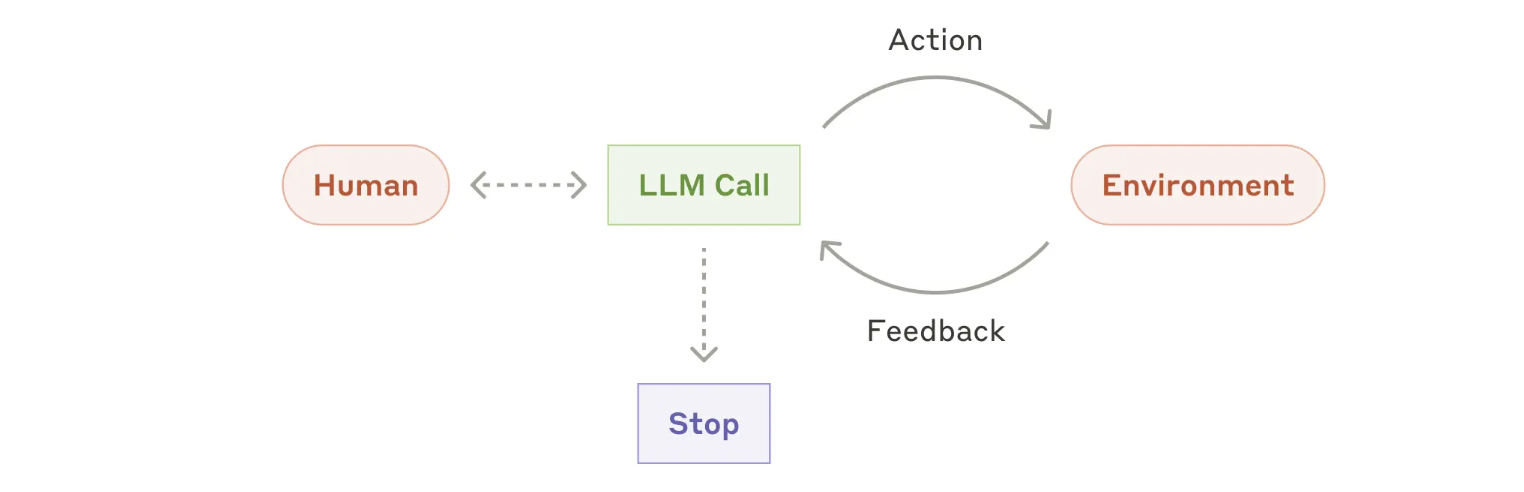

In [26]:
class ContentAgent:
    def __init__(self, client: Groq):
        self.client = client
        
    def generate_content(self, prompt: str, previous_content: Optional[str] = None, feedback: Optional[str] = None) -> str:
        if previous_content and feedback:
            system_prompt = """You are a helpful AI assistant. Review the previous content and user feedback, 
            then generate an improved version that addresses the feedback while maintaining quality and coherence."""
            
            full_prompt = f"""Previous content: {previous_content}
            User feedback: {feedback}
            Please provide an improved version that addresses this feedback."""
        else:
            system_prompt = "You are a helpful AI assistant. Generate high-quality content based on the user's request."
            full_prompt = prompt
            
        response = self.client.chat.completions.create(
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": full_prompt}
            ],
            model="mixtral-8x7b-32768",
            temperature=0.7,
        )
        
        return response.choices[0].message.content
    
def run_agent():
    agent = ContentAgent(client)
    
    # Get initial user request
    initial_prompt = input("What would you like me to write about? ")
    
    current_content = agent.generate_content(initial_prompt)
    
    while True:
        # Display current content
        print("\nCurrent content:")
        print("-" * 80)
        pprint(current_content)
        print("-" * 80)
        
        # Get user feedback
        print("\nIs this content good enough? Enter:")
        print("1. 'yes' if you're satisfied")
        print("2. 'no' and provide feedback for improvements")

        while True:
            response = input("Your response (yes/no): ").lower()
        
            if response == 'yes':
                print("\nGreat! Final content has been generated.")
                return
            elif response == 'no':
                feedback = input("Please provide specific feedback for improvements: ")
                current_content = agent.generate_content(initial_prompt, current_content, feedback)
                break
            else:
                print("Invalid response. Please enter 'yes' or 'no'.")

In [ ]:
run_agent()

## Tooling

1. User Sends a Message
	-	The user asks a question that might require a tool call (e.g., “What’s the weather in New York?”).
2.	Model Determines if a Tool is Needed
	-	If the model is configured to use tools, it can decide to call a tool instead of responding directly.
	-	It does this by returning a special “tool_calls” field instead of a normal response in message.content.
3.	Tool Executes & Returns Data
	-	The API (or your backend) executes the tool call (e.g., fetching weather data).
	-	The tool returns the result.
4.	Model Receives the Tool Response & Generates a Final Reply
	-	The tool’s response is passed back to the model in a new turn.
	-	The model can then use this tool response to generate a final user-facing message.

If the model decides to call a tool, the message.content will be None because the model isn’t directly responding yet. Instead, it returns a tool_calls object indicating that it wants external data.

After the tool response is received, the model can generate a final response that includes the tool’s data.

In [28]:
import requests
import geopy.geocoders
from getpass import getpass

In [29]:
my_email_address = getpass("Enter your email address (this is necessary to adher to terms and conditions at yr.no): ")

In [ ]:
my_email_address

In [31]:
def get_weather_for_city(city_name):
    """
    Fetch weather forecast for a given city using the met.no API.
    
    Args:
        city_name (str): Name of the city to get weather for
    
    Returns:
        dict: Weather forecast information
    """
    # Use geopy to get latitude and longitude
    geolocator = geopy.geocoders.Nominatim(user_agent="weather_assistant")
    try:
        location = geolocator.geocode(city_name)
        if not location:
            return {"error": f"Could not find coordinates for {city_name}"}
        
        # Construct met.no API request
        base_url = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
        params = {
            "lat": location.latitude,
            "lon": location.longitude
        }
        
        # Set headers as recommended by met.no
        headers = {
            "User-Agent": f"WeatherAssistant/1.0 ({my_email_address})",
            "Accept": "application/json"
        }
        
        # Make the API request
        response = requests.get(base_url, params=params, headers=headers)
        response.raise_for_status()
        
        # Parse the response
        weather_data = response.json()
        
        # Extract relevant information
        current_forecast = weather_data['properties']['timeseries'][0]['data']['instant']['details']
        return {
            "city": city_name,
            "temperature": current_forecast.get('air_temperature'),
            "wind_speed": current_forecast.get('wind_speed'),
            "humidity": current_forecast.get('relative_humidity'),
            "pressure": current_forecast.get('air_pressure_at_sea_level')
        }
    
    except Exception as e:
        return {"error": str(e)}


In [ ]:
get_weather_for_city("Stavanger")

In [33]:
# Define the tool/function
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather_for_city",
            "description": "Retrieve current weather information for a specified city",
            "parameters": {
                "type": "object",
                "properties": {
                    "city_name": {
                        "type": "string",
                        "description": "The name of the city to get weather information for"
                    }
                },
                "required": ["city_name"]
            }
        }
    }
]

In [39]:
user_question = "What is the current weather in Stavanger?"
#user_question = "What is the meaning of life?"

In [48]:

# Create a chat completion with the weather tool
chat_completion = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[
        {
            "role": "system", 
            "content": "You are a helpful weather assistant. When asked about weather, use the get_weather_for_city function to retrieve information."
        },
        {
            "role": "user", 
            "content": f"{user_question}"
        }
    ],
    tools=tools,
    tool_choice="auto"
)

tool_response = chat_completion.choices[0]

In [ ]:
print(f'{tool_response.finish_reason=}')
print(f"{tool_response.message.tool_calls=}")
print(f"{tool_response.message.content=}")

In [ ]:
# Check if a tool call was made and extract the relevant information
weather_info = None
if tool_response.finish_reason == "tool_calls":
    tool_calls = tool_response.message.tool_calls
    for tool_call in tool_calls:
        if tool_call.function.name == "get_weather_for_city":
            # Parse the arguments
            city_name = json.loads(tool_call.function.arguments)['city_name']
            
            # Call the actual function
            weather_info = get_weather_for_city(city_name)
            
            # Display the weather information
            print(f"Weather in {city_name}:")
            print(json.dumps(weather_info, indent=2))


In [ ]:
if weather_info:
    weather_system_prompt = "You are a helpful weather assistant. When asked about weather, respond with the weather information and specify that it is real-time and up-to-date."

    final_response = llm_call(prompt=f"{user_question}\n{json.dumps(weather_info)}", system_prompt=weather_system_prompt)
    print(final_response)